In [1]:
import random
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import joblib
import pickle

import logging
from Lib.DataLoader import DataLoader
from Lib.Diagnoser import Diagnoser

logging.basicConfig(level=logging.ERROR)

def load_split_data(file_path, num_fields, separator, skip_title, cls_col, start_feature_col, end_feature_col):
    dl = DataLoader()
    lines = dl.load_data_lines(file_path, num_fields=num_fields, separator=separator, skip_title=skip_title, shuffle=True)
    train_lines, val_lines = dl.split_data_by_cls_num(lines, cls_col)
    train_X = [[int(e) for e in l[start_feature_col:end_feature_col+1]] for l in train_lines]
    train_y = [int(l[cls_col]) for l in train_lines]
    val_X = [[int(e) for e in l[start_feature_col:end_feature_col+1]] for l in val_lines]
    val_y = [int(l[cls_col])for l in val_lines]
    val_id = [l[0:2] for l in val_lines]

    return train_X, train_y, val_X, val_y, val_id


def load_data(file_path, num_fields, separator, skip_title, cls_col, start_feature_col, end_feature_col, shuffle=True):
    dl = DataLoader()
    lines = dl.load_data_lines(file_path, num_fields=num_fields, separator=separator, skip_title=skip_title, shuffle=shuffle)
    X = [[int(e) for e in l[start_feature_col:end_feature_col+1]] for l in lines]
    y = [int(l[cls_col]) for l in lines]
    ids = [l[0:2] for l in lines]

    return X, y, ids

def load_data_arr(file_path_arr, num_fields, separator, skip_title, cls_col, start_feature_col, end_feature_col):
    X, y, ids = [], [], []
    for file_path in file_path_arr:
        X_, y_, ids_ = load_data(file_path, num_fields, separator, skip_title, cls_col, start_feature_col, end_feature_col)
        X.extend(X_)
        y.extend(y_)
        ids.extend(ids_)

    return X, y, ids


def write_pred_result(val_id, val_y, prediction, model_name):
    with open(r'output/logs/%s.txt' % model_name, 'w') as f:
        for (id, dt), y, y_ in zip(val_id, val_y, prediction):
            f.write('%s	%s	%s	%s\n' % (id, dt, y, y_))

def run_test(scaler, model, X, y):
    X = scaler.transform(X)
    prediction = model.predict(X)
    matrix = metrics.confusion_matrix(y, prediction)
    accuracy = metrics.accuracy_score(y, prediction)
    print('准确率: {:.2%}'.format(accuracy))

In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

font = FontProperties(fname="SimHei.ttf", size=14)
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        print(cm)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("显示百分比：")
#         np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
    else:
        cm_ = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
#         print('显示具体数字：')
#         print(cm_)
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # matplotlib版本问题，如果不加下面这行代码，则绘制的混淆矩阵上下只能显示一半，有的版本的matplotlib不需要下面的代码，分别试一下即可
    plt.ylim(len(classes) - 0.5, -0.5)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontproperties=font)
    plt.xlabel('Predicted label', fontproperties=font)
    plt.show()


In [3]:
tags = ["急性阑尾炎", "急性胰腺炎", "肠梗阻", "异位妊娠", "急性胆管炎", "急性胆囊炎", "上尿路结石", "卵巢囊肿破裂", "卵巢囊肿扭转", "消化道穿孔"]

def train_and_save(model, train_X, train_y, val_X, val_y, val_id, model_name):
    ss = StandardScaler()
    train_X = ss.fit_transform(train_X)
    val_X = ss.transform(val_X)
    
#     # 创建分类器
#     # model = svm.SVC()
#     model = GradientBoostingClassifier(max_features=90, max_depth=40, min_samples_split=8, min_samples_leaf=3,
#                                     n_estimators=1200, learning_rate=0.05, subsample=0.95)

    # 用训练集做训练
    model.fit(train_X, train_y)
    # 用测试集做预测
    prediction=model.predict(val_X)
    # 混淆矩阵
    matrix = metrics.confusion_matrix(val_y, prediction)
    plot_confusion_matrix(matrix, tags, False, 'Confusion matrix')
    
    # 准确率
    accuracy = metrics.accuracy_score(val_y, prediction)
    print('准确率: {:.2%}'.format(accuracy))

    model_save_name = "%s_%.4f" % (model_name, accuracy)
    scaler_save_name = "scaler_%s" % (model_name)
    # 写结果
    write_pred_result(val_id, val_y, prediction, model_save_name)
    
    # 写模型
    joblib.dump(model, r"output/models/diagnose/%s.m" % model_save_name)
    
    # 保存标准化器
    pickle.dump(ss, open(r"output/models/diagnose/%s.pkl" % scaler_save_name, 'wb'))
    

def test_and_save(pred, y, ids, model_name):
    matrix = metrics.confusion_matrix(y, pred)
    plot_confusion_matrix(matrix, tags, False, 'Confusion matrix')

    # 准确率
    accuracy = metrics.accuracy_score(y, pred)
    print('准确率: {:.2%}'.format(accuracy))

    # 写结果
    write_pred_result(ids, y, pred, model_name)

### 全量数据拆分

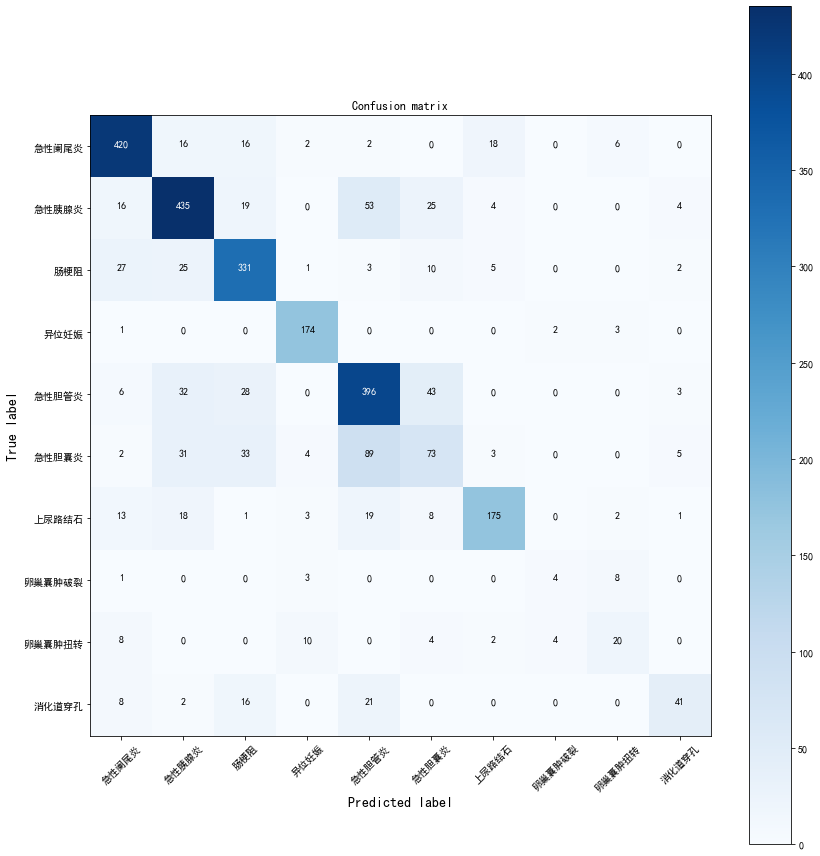

准确率: 74.96%


In [8]:
X_train, y_train, _ = load_data(r'data/疾病诊断拟合_全特征合成2345.txt', 
                num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170, shuffle=True)
X_val, y_val, ids_val = load_data(r'data/疾病诊断拟合_全特征合成1.txt', 
                num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170, shuffle=False)
model = GradientBoostingClassifier(max_features=90, max_depth=40, min_samples_split=8, min_samples_leaf=3,
                                    n_estimators=1200, learning_rate=0.05, subsample=0.95)

train_and_save(model, X_train, y_train, X_val, y_val, ids_val, 'gbdt_全量合成拆分')

### 全量数据 + 合成数据

6
6
6
6
4, total num: 2548, train num: 2038
1, total num: 2780, train num: 2224
2, total num: 2020, train num: 1616
0, total num: 2408, train num: 1926
5, total num: 1200, train num: 960
3, total num: 908, train num: 726
6, total num: 1196, train num: 957
9, total num: 448, train num: 358
8, total num: 232, train num: 186
7, total num: 84, train num: 67


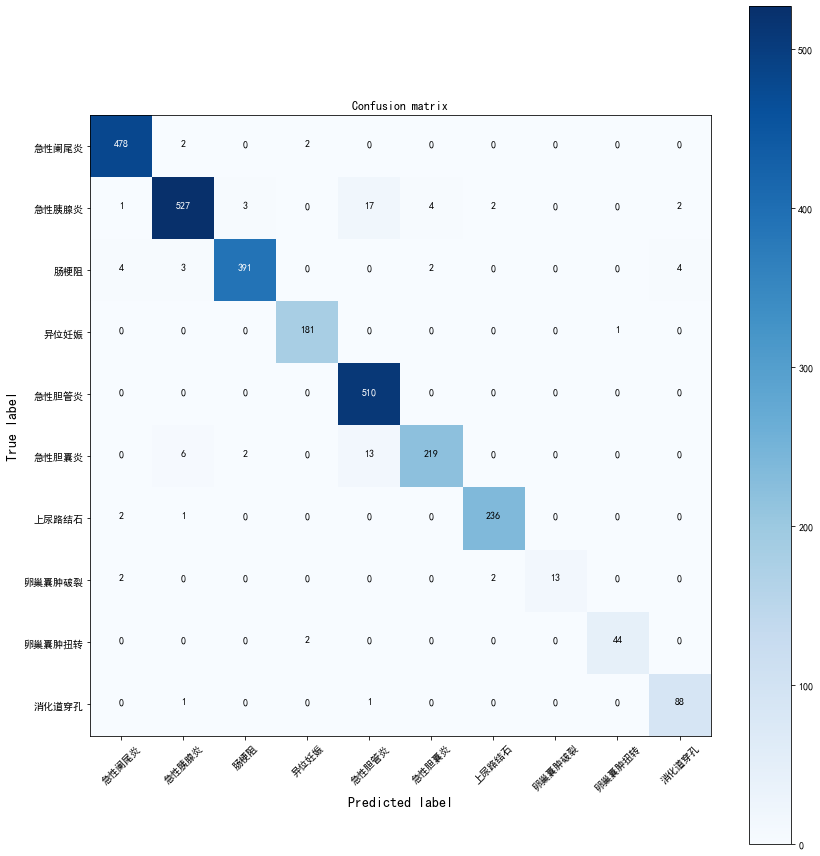

准确率: 97.14%


In [5]:
X_train, y_train, X_val, y_val, ids_val = load_split_data(r'data/疾病诊断拟合_全特征合成.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
model = GradientBoostingClassifier(max_features=90, max_depth=40, min_samples_split=8, min_samples_leaf=3,
                                    n_estimators=1200, learning_rate=0.05, subsample=0.95)

train_and_save(model, X_train, y_train, X_val, y_val, ids_val, 'gbdt_全量合成')


### 人机大赛生成系统数据

In [8]:
X, y, ids = load_data(r'data/人机大赛_临床合成.txt',  num_fields=171, separator='	', skip_title=True, 
                           cls_col=2, start_feature_col=3, end_feature_col=170, shuffle=False)
# dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_全特征2345.pkl', r'output/models/diagnose/gbdt_全特征2345_0.8258.m')
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_临床合成2345.pkl', r'output/models/diagnose/gbdt_临床合成2345_0.7058.m')
results = dg.predict_batch(X, pred_num=5, dict_name_id='dict')
with open(r'output/data/tmp.txt', 'w') as f:
    for r in results:
        f.write('%s\n' % str(r))


### 人机大赛数据测试

In [4]:
from Lib.Diagnoser import Diagnoser

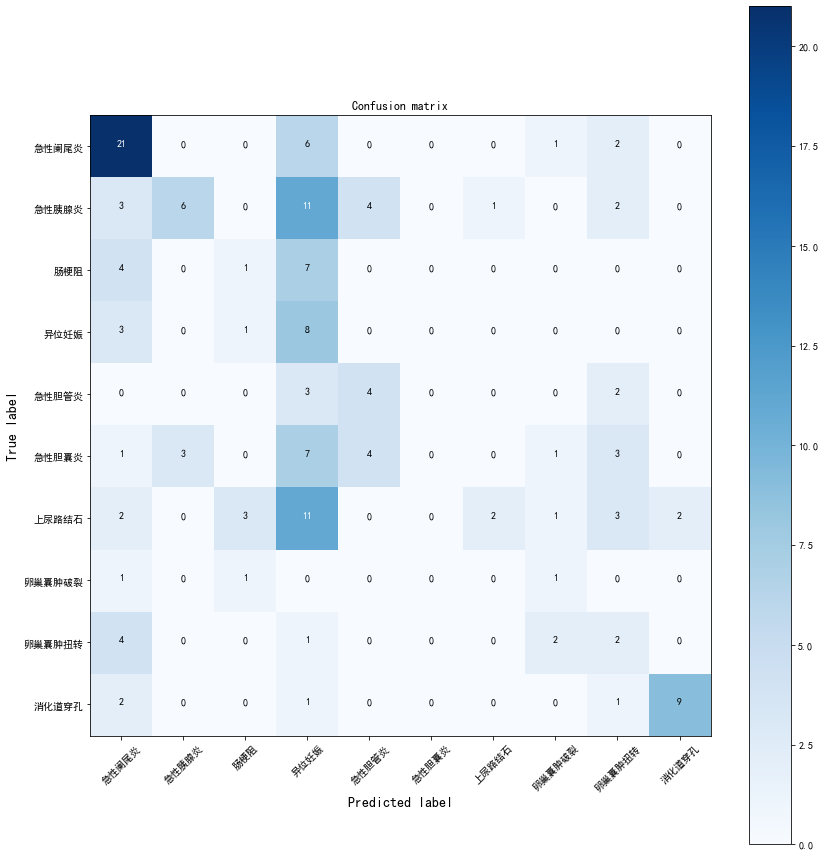

准确率: 34.18%


In [7]:
X, y, ids = load_data(r'data/人机大赛_临床合成.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_全量合成.pkl', r'output/models/diagnose/gbdt_全量合成_0.9714.m')
pred = dg.predict_one(X)

test_and_save(pred, y, ids, 'gbdt_全量合成')

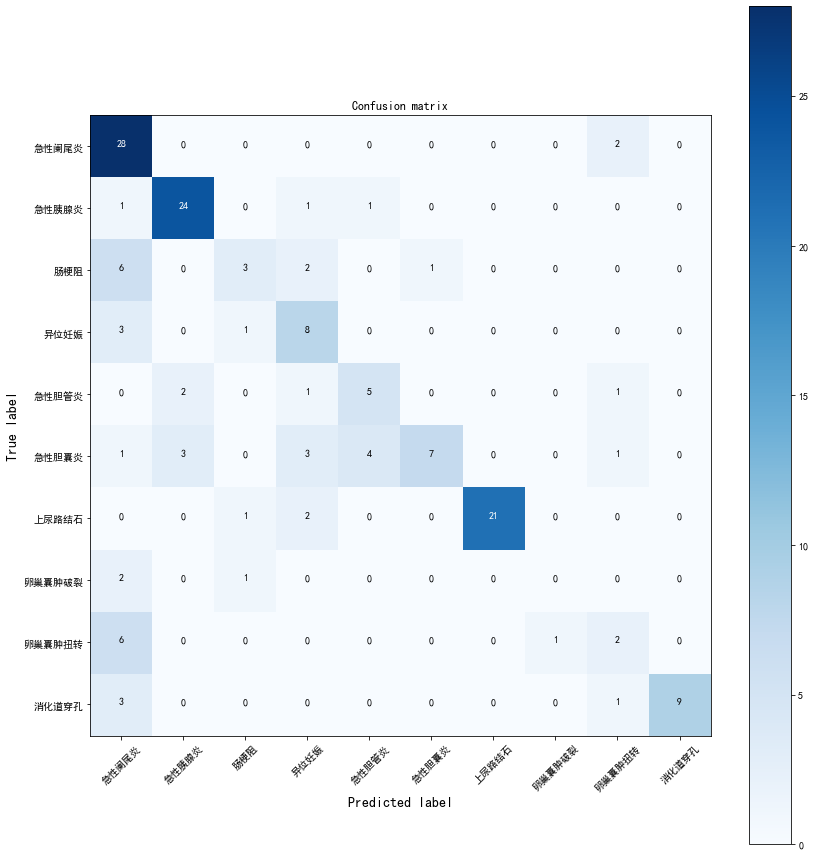

准确率: 67.72%


In [8]:
X, y, ids = load_data(r'data/人机大赛_全特征.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_全量合成.pkl', r'output/models/diagnose/gbdt_全量合成_0.9714.m')
pred = dg.predict_one(X)

test_and_save(pred, y, ids, 'gbdt_全量合成')

In [10]:
X, y, ids = load_data(r'data/疾病诊断拟合_临床合成.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_全量合成.pkl', r'output/models/diagnose/gbdt_全量合成_0.9714.m')
pred = dg.predict_one(X)

test_and_save(pred, y, ids, 'gbdt_全量合成_临床合成')

FileNotFoundError: [Errno 2] No such file or directory: 'data/疾病诊断拟合_临床合成.txt'

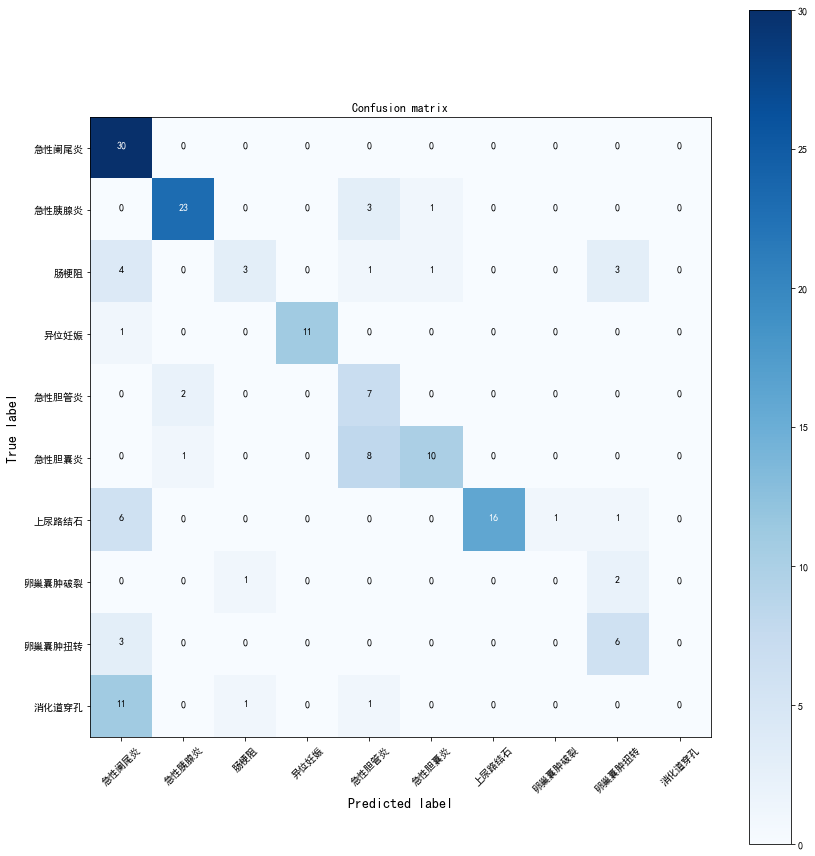

准确率: 67.09%


In [11]:
X, y, ids = load_data(r'data/人机大赛_全特征.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_全量特征.pkl', r'output/models/diagnose/gbdt_全量特征_0.8497.m')
pred = dg.predict_one(X)

test_and_save(pred, y, ids, 'gbdt_全量特征_人机大赛')

### 全量数据

6


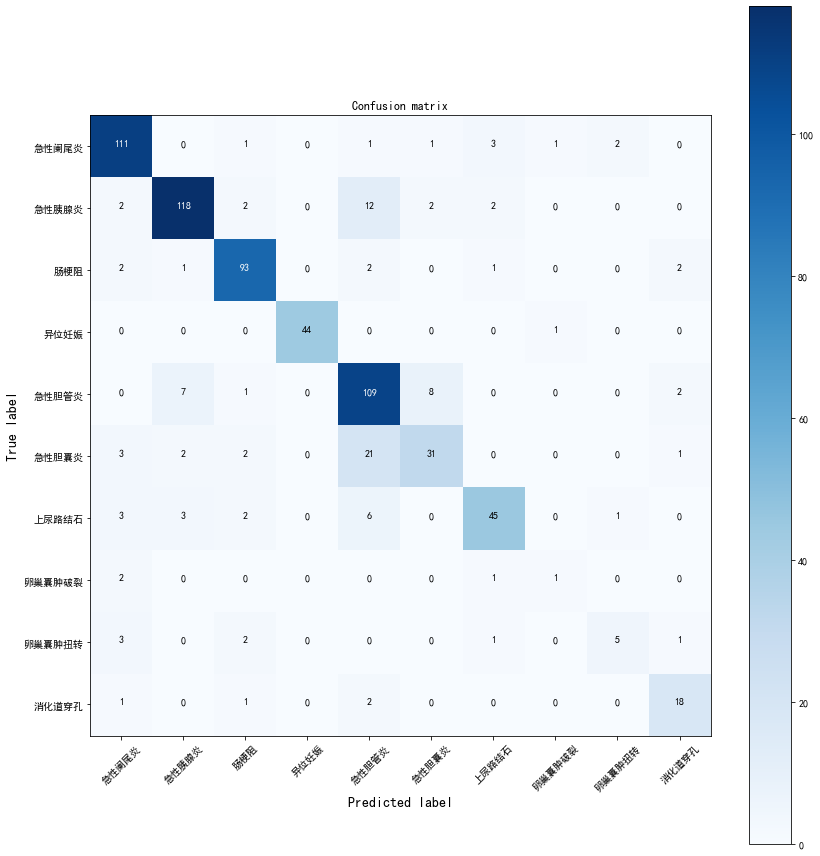

准确率: 83.45%


In [12]:
X_train, y_train, ids_train = load_data_arr([r'data/疾病诊断拟合_全特征_1.txt', r'data/疾病诊断拟合_全特征_2.txt', 
                           r'data/疾病诊断拟合_全特征_3.txt', r'data/疾病诊断拟合_全特征_4.txt'],
                          num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
X_val, y_val, ids_val = load_data(r'data/疾病诊断拟合_全特征_5.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
    
# 创建分类器
# model = svm.SVC()
model = GradientBoostingClassifier(max_features=90, max_depth=40, min_samples_split=8, min_samples_leaf=3,
                                    n_estimators=1200, learning_rate=0.05, subsample=0.95)

train_and_save(model, X_train, y_train, X_val, y_val, ids_val, 'gbdt_全量特征')

6


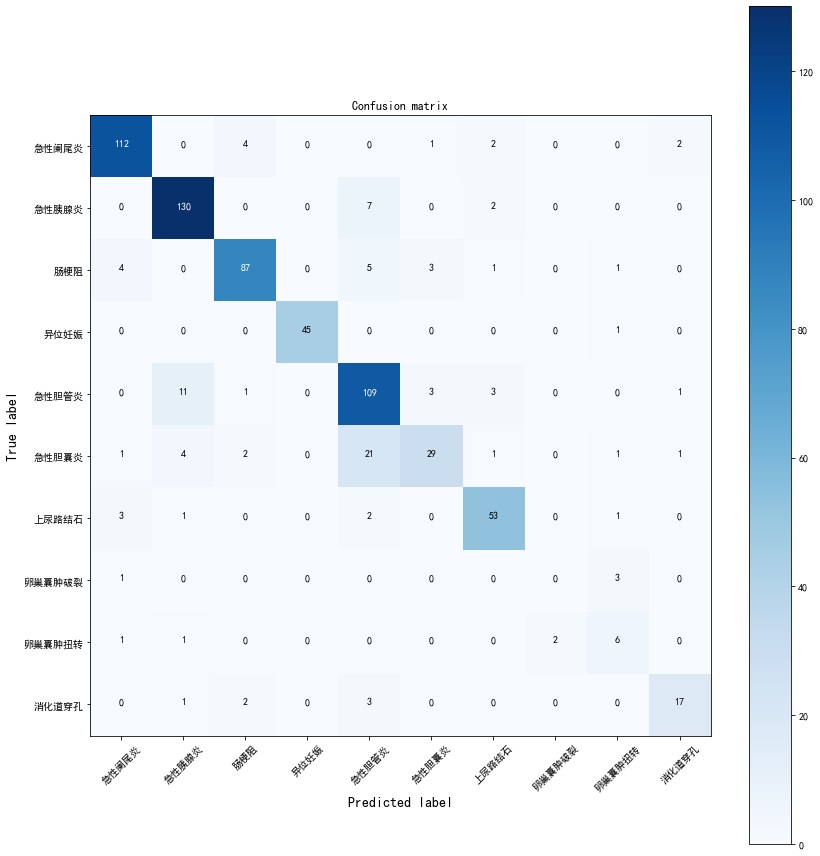

准确率: 84.97%


In [13]:
X_train, y_train, ids_train = load_data_arr([r'data/疾病诊断拟合_全特征_1.txt', r'data/疾病诊断拟合_全特征_2.txt', 
                           r'data/疾病诊断拟合_全特征_3.txt', r'data/疾病诊断拟合_全特征_5.txt'],
                          num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
X_val, y_val, ids_val = load_data(r'data/疾病诊断拟合_全特征_4.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)

scaler, model = train_and_save(X_train, y_train, X_val, y_val, ids_val, 'gbdt_全量特征')

6


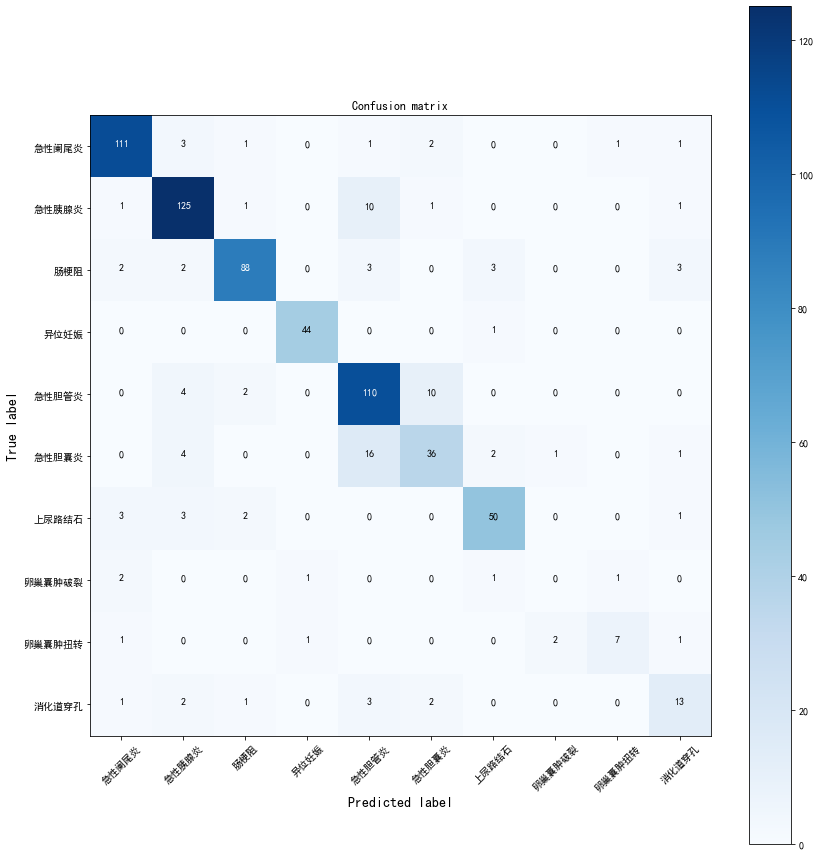

准确率: 84.76%


In [14]:
X_train, y_train, ids_train = load_data_arr([r'data/疾病诊断拟合_全特征_1.txt', r'data/疾病诊断拟合_全特征_2.txt', 
                           r'data/疾病诊断拟合_全特征_4.txt', r'data/疾病诊断拟合_全特征_5.txt'],
                          num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
X_val, y_val, ids_val = load_data(r'data/疾病诊断拟合_全特征_3.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)

scaler, model = train_and_save(X_train, y_train, X_val, y_val, ids_val, 'gbdt_全量特征')

6


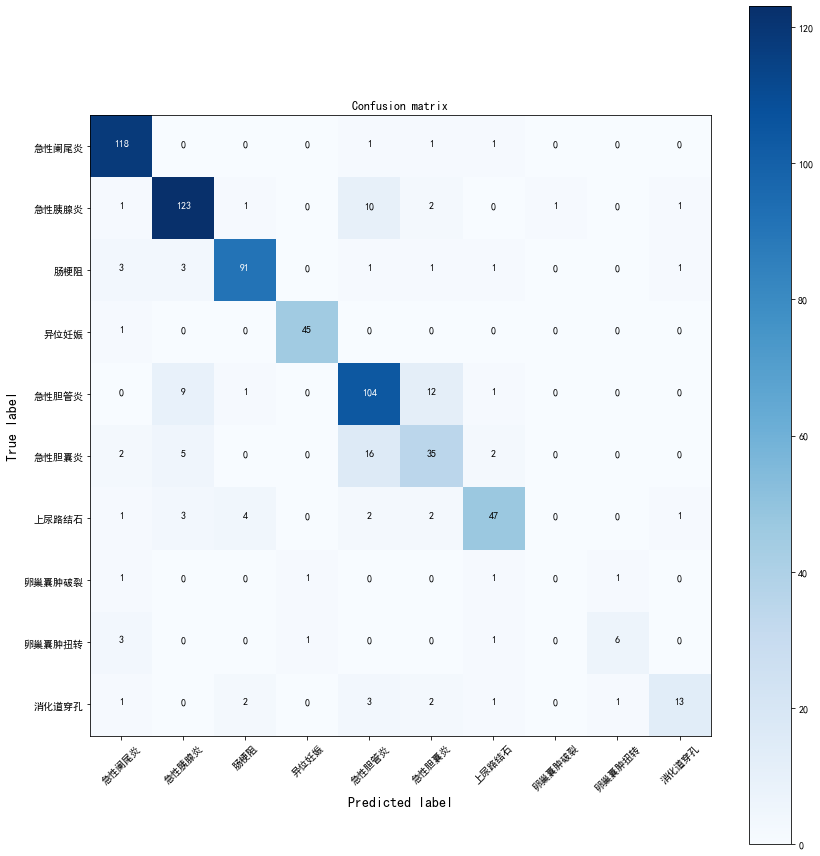

准确率: 84.10%


In [15]:
X_train, y_train, ids_train = load_data_arr([r'data/疾病诊断拟合_全特征_1.txt', r'data/疾病诊断拟合_全特征_3.txt', 
                           r'data/疾病诊断拟合_全特征_4.txt', r'data/疾病诊断拟合_全特征_5.txt'],
                          num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
X_val, y_val, ids_val = load_data(r'data/疾病诊断拟合_全特征_2.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)

scaler, model = train_and_save(X_train, y_train, X_val, y_val, ids_val, 'gbdt_全量特征')

6


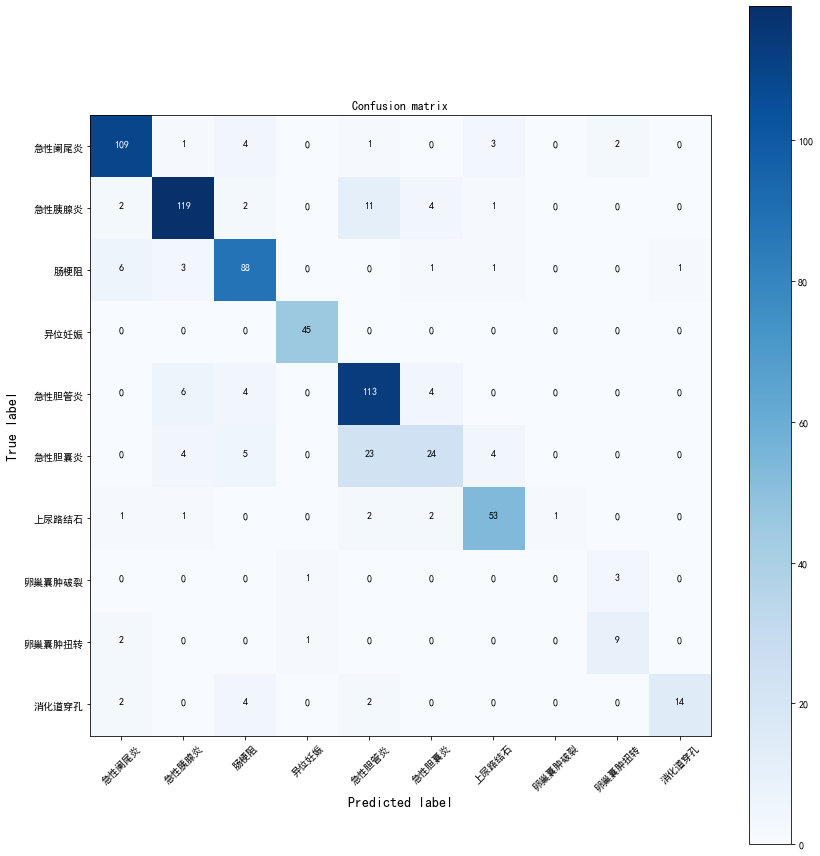

准确率: 83.31%


In [19]:
X_train, y_train, ids_train = load_data_arr([r'data/疾病诊断拟合_全特征_3.txt', r'data/疾病诊断拟合_全特征_2.txt', 
                           r'data/疾病诊断拟合_全特征_4.txt', r'data/疾病诊断拟合_全特征_5.txt'],
                          num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
X_val, y_val, ids_val = load_data(r'data/疾病诊断拟合_全特征_1.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)

scaler, model = train_and_save(X_train, y_train, X_val, y_val, ids_val, 'gbdt_全量特征')

### 临床数据

6
0, total num: 602, train num: 482
2, total num: 505, train num: 404
1, total num: 695, train num: 556
4, total num: 637, train num: 510
6, total num: 299, train num: 239
5, total num: 300, train num: 240
8, total num: 58, train num: 46
3, total num: 227, train num: 182
9, total num: 112, train num: 90
7, total num: 21, train num: 17


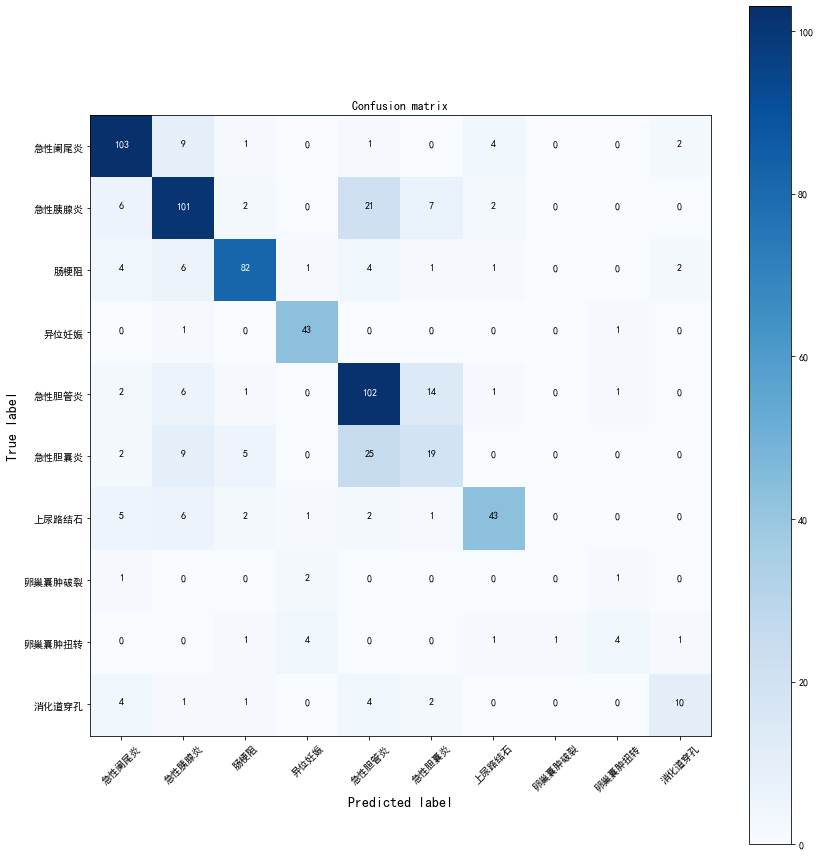

准确率: 73.48%


(StandardScaler(),
 GradientBoostingClassifier(learning_rate=0.05, max_depth=40, max_features=90,
                            min_samples_leaf=3, min_samples_split=8,
                            n_estimators=1200, subsample=0.95))

In [6]:
train_X, train_y, val_X, val_y, val_id = load_data(r'data/疾病诊断拟合_临床.txt', num_fields=121, separator='	',
    skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=120)

train_and_save(train_X, train_y, val_X, val_y, val_id, 'gbdt_临床特征')

### 临床 + 实验室

6
0, total num: 602, train num: 482
6, total num: 299, train num: 239
3, total num: 227, train num: 182
9, total num: 112, train num: 90
2, total num: 505, train num: 404
8, total num: 58, train num: 46
4, total num: 637, train num: 510
5, total num: 300, train num: 240
1, total num: 695, train num: 556
7, total num: 21, train num: 17


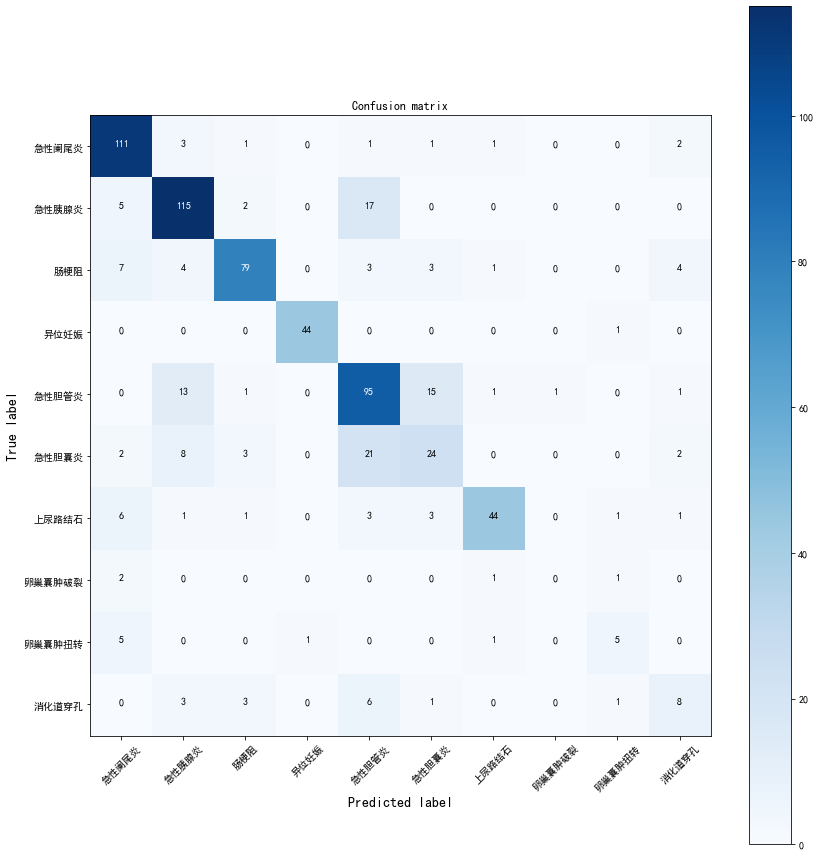

准确率: 76.09%


(StandardScaler(),
 GradientBoostingClassifier(learning_rate=0.05, max_depth=40, max_features=90,
                            min_samples_leaf=3, min_samples_split=8,
                            n_estimators=1200, subsample=0.95))

In [7]:
train_X, train_y, val_X, val_y, val_id = load_data(r'data/疾病诊断拟合_临床+实验室.txt', num_fields=139, separator='	',
        skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=138)

train_and_save(train_X, train_y, val_X, val_y, val_id, 'gbdt_临床实验室')

### 临床合成

1, total num: 695, train num: 556
3, total num: 227, train num: 182
6, total num: 299, train num: 239
8, total num: 58, train num: 46
0, total num: 602, train num: 482
2, total num: 505, train num: 404
5, total num: 300, train num: 240
4, total num: 637, train num: 510
7, total num: 21, train num: 17
9, total num: 112, train num: 90


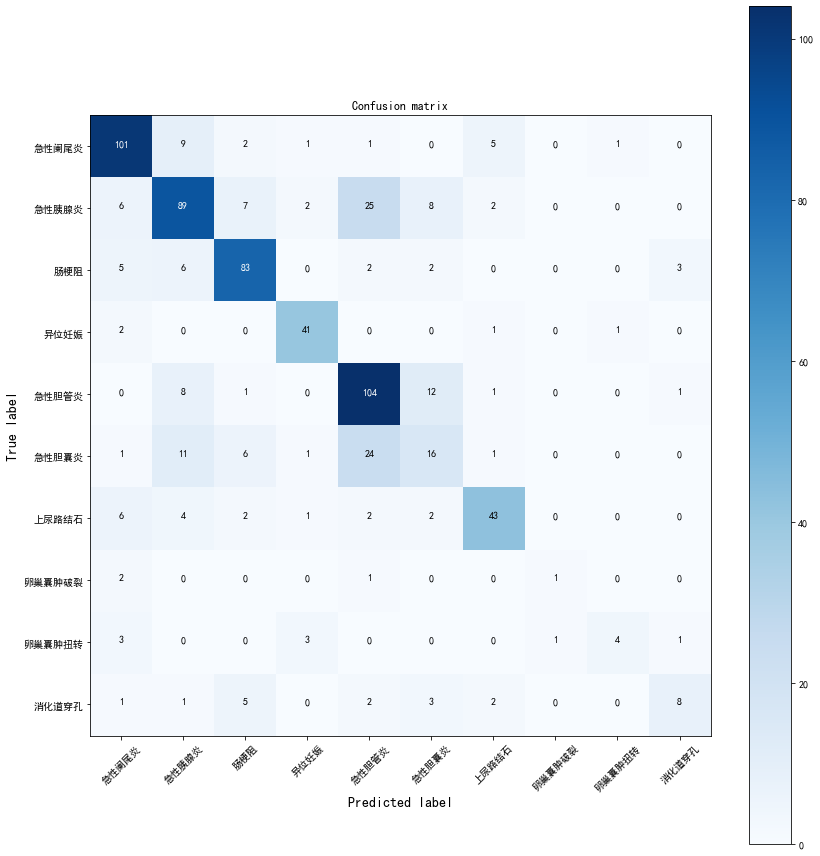

准确率: 71.01%


In [6]:
X_train, y_train, X_val, y_val, ids_val = load_split_data(r'data/疾病诊断拟合_临床合成.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
model = GradientBoostingClassifier(max_features=90, max_depth=40, min_samples_split=8, min_samples_leaf=3,
                                    n_estimators=1200, learning_rate=0.05, subsample=0.95)

train_and_save(model, X_train, y_train, X_val, y_val, ids_val, 'gbdt_临床合成')


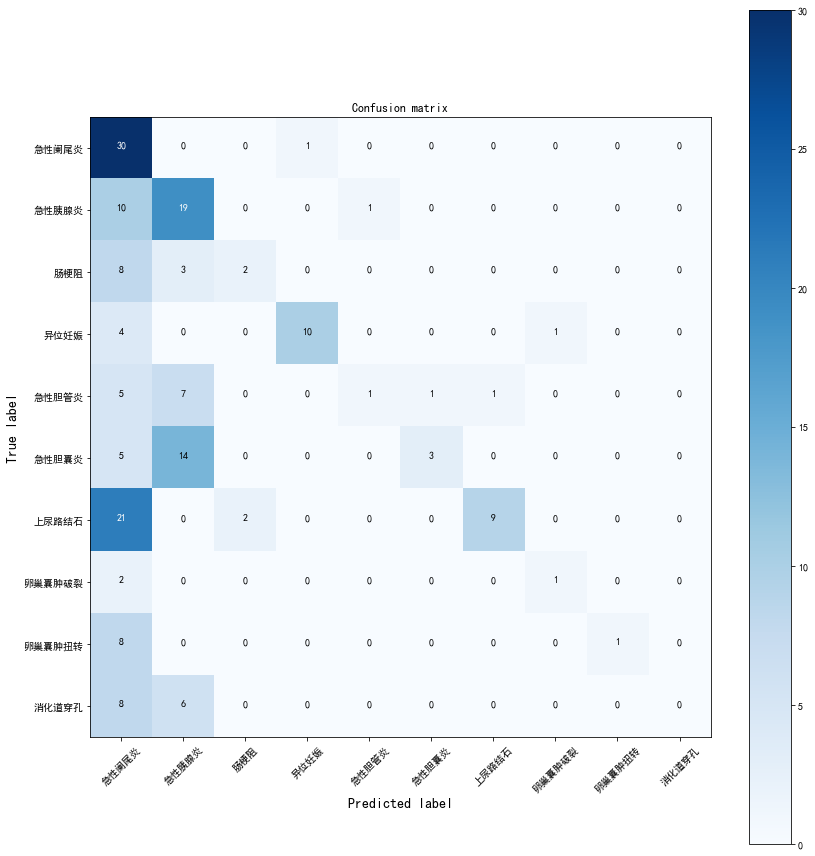

准确率: 41.30%


In [7]:
X, y, ids = load_data(r'data/人机大赛_临床合成.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_临床合成.pkl', r'output/models/diagnose/gbdt_临床合成_0.7101.m')
pred = dg.predict_one(X)

test_and_save(pred, y, ids, 'gbdt_人机大赛_临床合成')

### 临床实验室合成

6, total num: 299, train num: 239
0, total num: 602, train num: 482
9, total num: 112, train num: 90
4, total num: 637, train num: 510
1, total num: 695, train num: 556
5, total num: 300, train num: 240
2, total num: 505, train num: 404
3, total num: 227, train num: 182
7, total num: 21, train num: 17
8, total num: 58, train num: 46


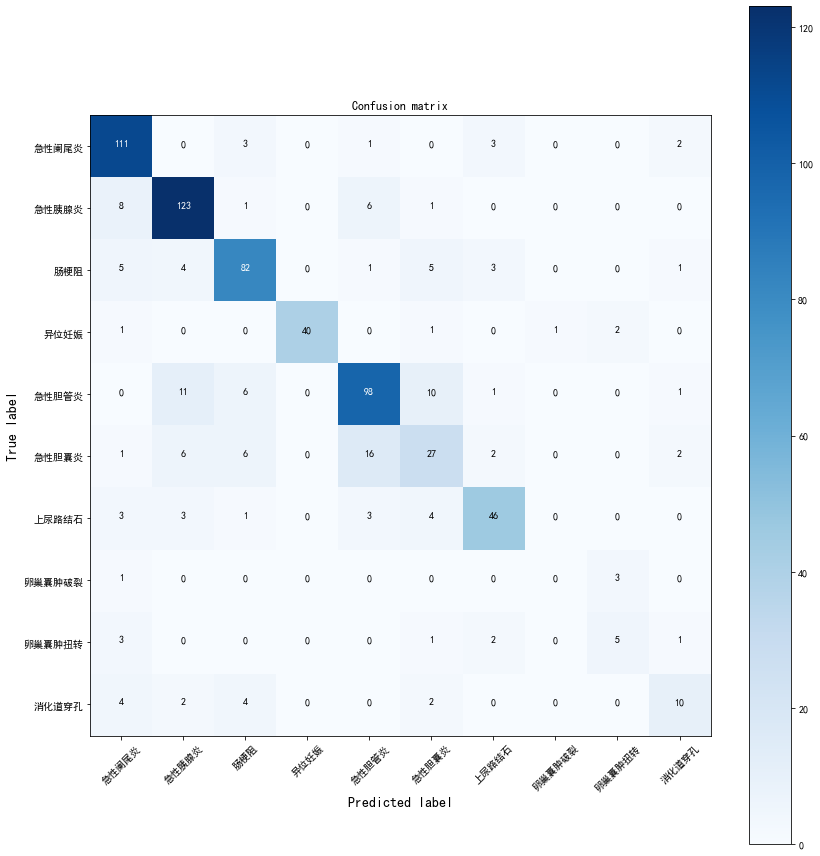

准确率: 78.55%


In [8]:
X_train, y_train, X_val, y_val, ids_val = load_split_data(r'data/疾病诊断拟合_临床实验室合成.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
model = GradientBoostingClassifier(max_features=90, max_depth=40, min_samples_split=8, min_samples_leaf=3,
                                    n_estimators=1200, learning_rate=0.05, subsample=0.95)

train_and_save(model, X_train, y_train, X_val, y_val, ids_val, 'gbdt_临床实验室合成')

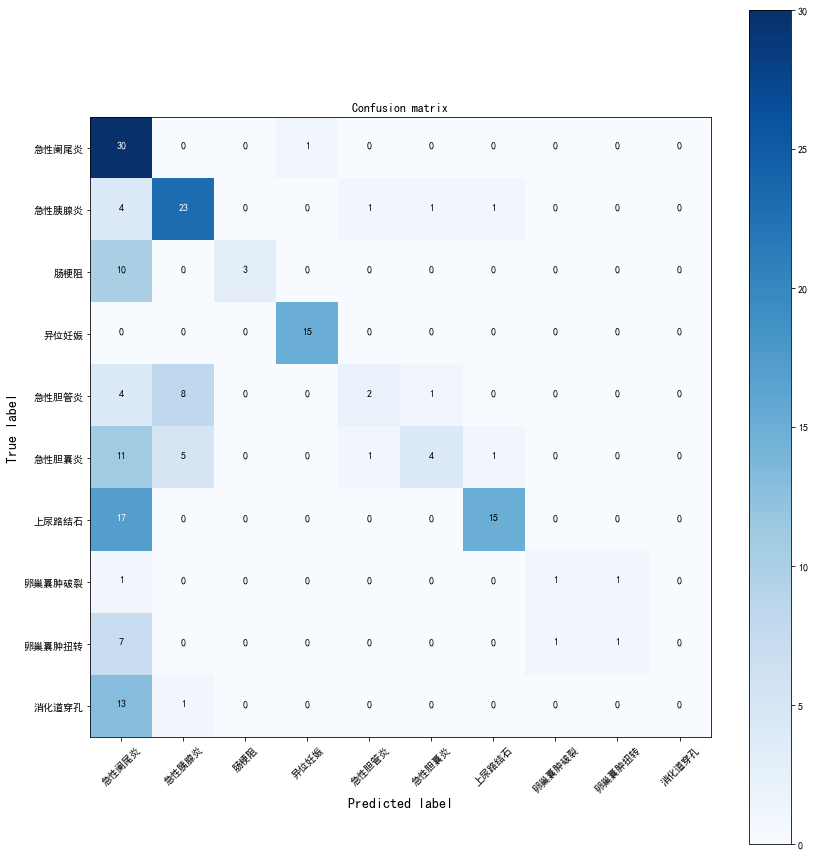

准确率: 51.09%


In [9]:
X, y, ids = load_data(r'data/人机大赛_临床实验室合成.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_临床实验室合成.pkl', r'output/models/diagnose/gbdt_临床实验室合成_0.7855.m')
pred = dg.predict_one(X)

test_and_save(pred, y, ids, 'gbdt_人机大赛_临床实验室合成')

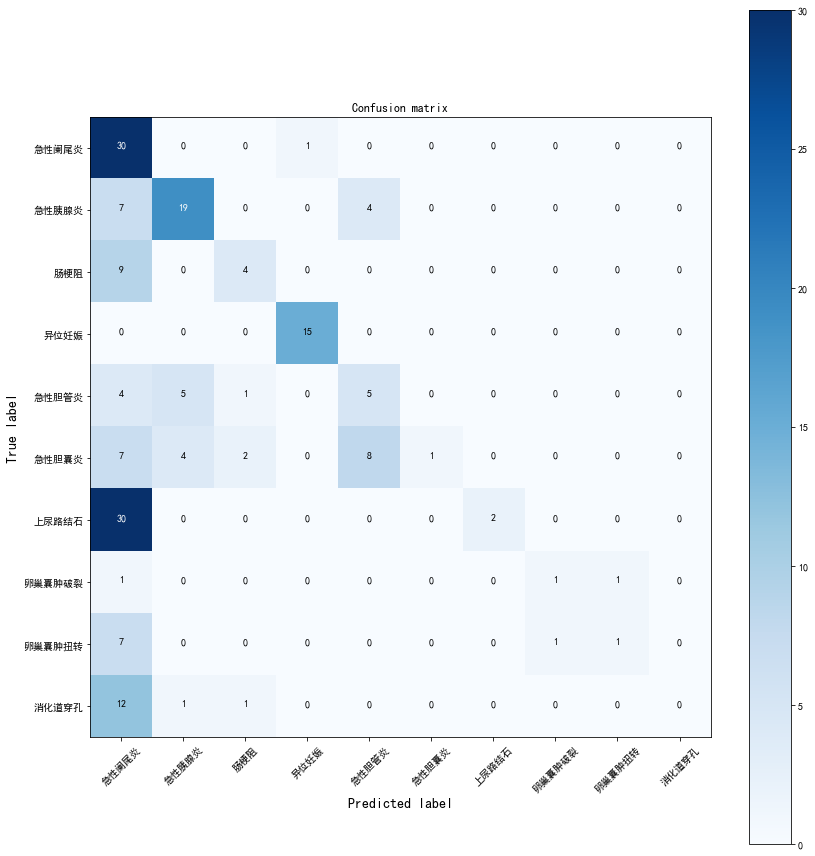

准确率: 42.39%


In [9]:
X, y, ids = load_data(r'data/人机大赛_临床实验室合成.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_全量特征.pkl', r'output/models/diagnose/gbdt_全量特征_0.8497.m')
pred = dg.predict_one(X)

test_and_save(pred, y, ids, 'gbdt_人机大赛_全量特征模型_临床实验室合成')

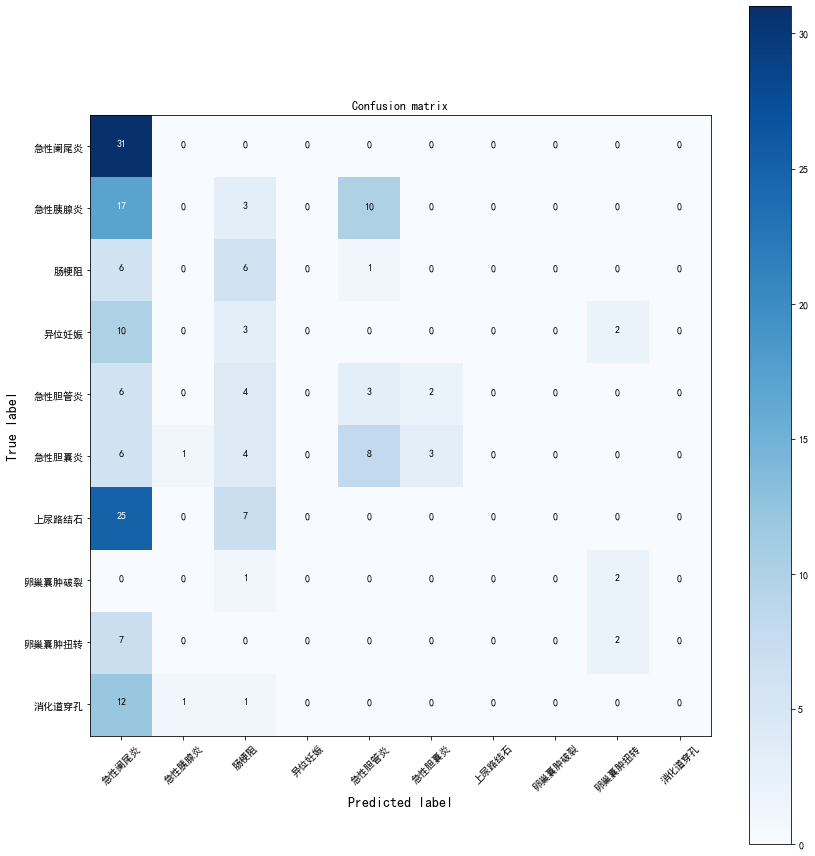

准确率: 24.46%


In [10]:
X, y, ids = load_data(r'data/人机大赛_临床合成.txt',
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_全量特征.pkl', r'output/models/diagnose/gbdt_全量特征_0.8497.m')
pred = dg.predict_one(X)

test_and_save(pred, y, ids, 'gbdt_人机大赛_全量特征模型_临床合成')

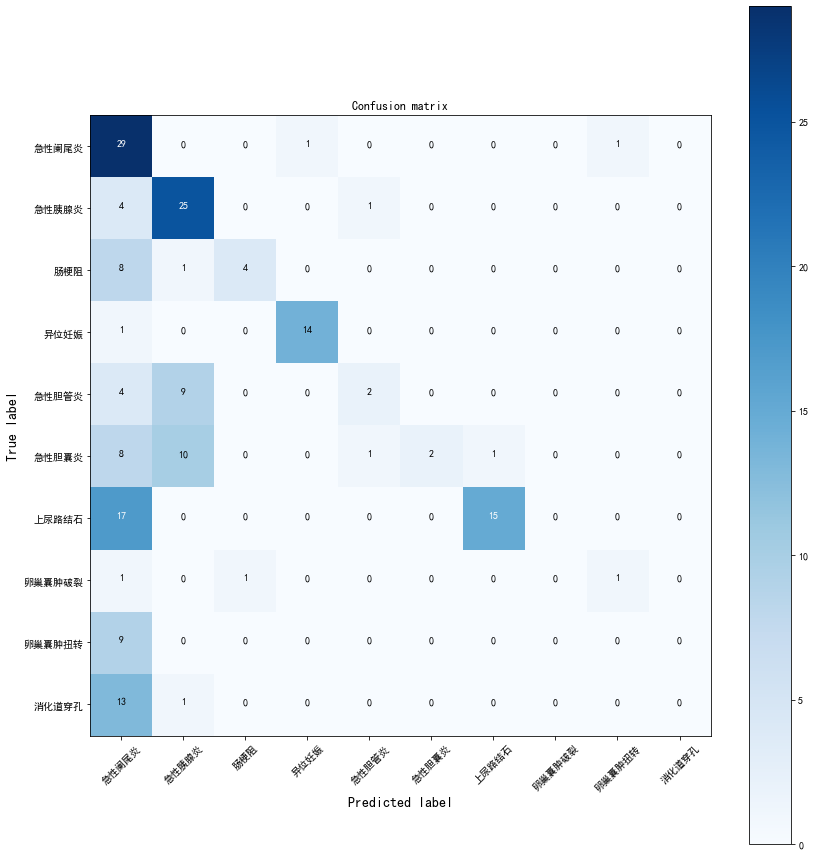

准确率: 49.46%


In [11]:
X, y, ids = load_data(r'data/人机大赛_临床实验室合成.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_全量合成.pkl', r'output/models/diagnose/gbdt_全量合成_0.9714.m')
pred = dg.predict_one(X)

test_and_save(pred, y, ids, 'gbdt_人机大赛_全量特征模型_临床实验室合成')

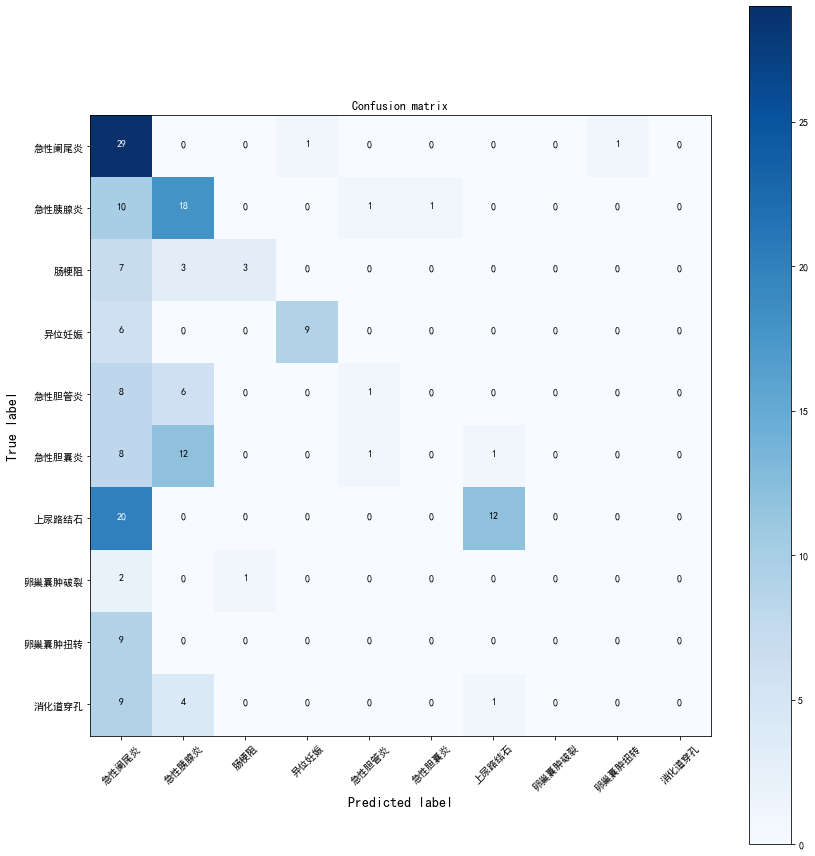

准确率: 39.13%


In [12]:
X, y, ids = load_data(r'data/人机大赛_临床合成.txt',
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_全量合成.pkl', r'output/models/diagnose/gbdt_全量合成_0.9714.m')
pred = dg.predict_one(X)

test_and_save(pred, y, ids, 'gbdt_人机大赛_全量特征模型_临床合成')

### 固定数据集训练三个模型

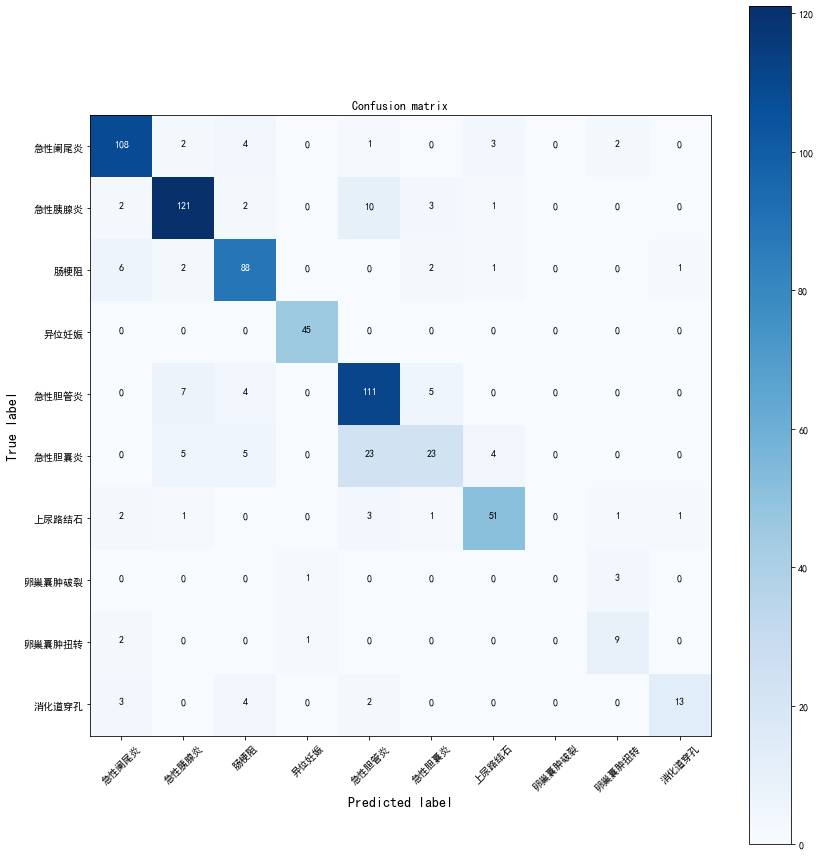

准确率: 82.58%


In [13]:
X_train, y_train, _ = load_data(r'data/疾病诊断拟合_全特征_2345.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
X_val, y_val, ids_val = load_data(r'data/疾病诊断拟合_全特征_1.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
model = GradientBoostingClassifier(max_features=90, max_depth=40, min_samples_split=8, min_samples_leaf=3,
                                    n_estimators=1200, learning_rate=0.05, subsample=0.95)

train_and_save(model, X_train, y_train, X_val, y_val, ids_val, 'gbdt_全特征2345')


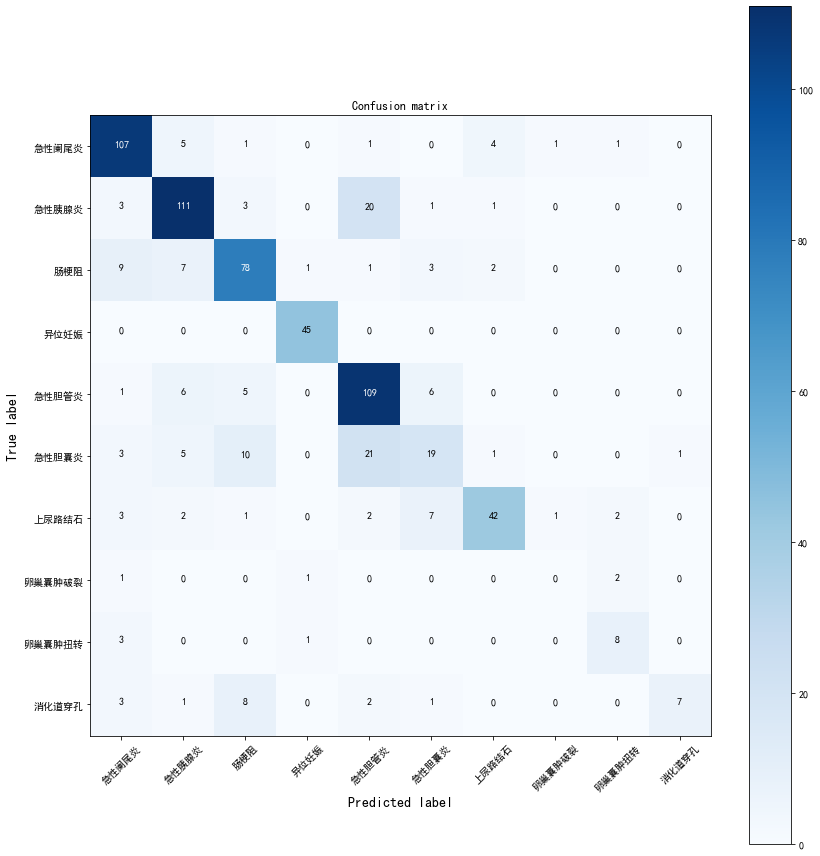

准确率: 76.23%


In [14]:
X_train, y_train, _ = load_data(r'data/疾病诊断拟合_临床实验室合成2345.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
X_val, y_val, ids_val = load_data(r'data/疾病诊断拟合_临床实验室合成1.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
model = GradientBoostingClassifier(max_features=90, max_depth=40, min_samples_split=8, min_samples_leaf=3,
                                    n_estimators=1200, learning_rate=0.05, subsample=0.95)

train_and_save(model, X_train, y_train, X_val, y_val, ids_val, 'gbdt_临床实验室合成2345')

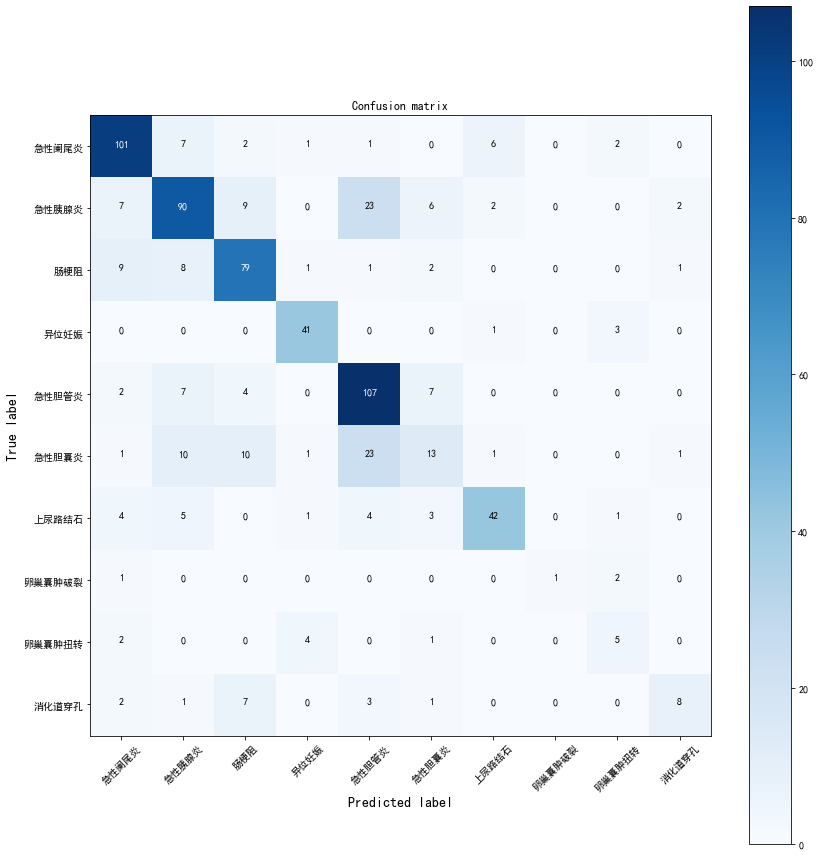

准确率: 70.58%


In [15]:
X_train, y_train, _ = load_data(r'data/疾病诊断拟合_临床合成2345.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
X_val, y_val, ids_val = load_data(r'data/疾病诊断拟合_临床合成1.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
model = GradientBoostingClassifier(max_features=90, max_depth=40, min_samples_split=8, min_samples_leaf=3,
                                    n_estimators=1200, learning_rate=0.05, subsample=0.95)

train_and_save(model, X_train, y_train, X_val, y_val, ids_val, 'gbdt_临床合成2345')

### 人机大赛数据预测

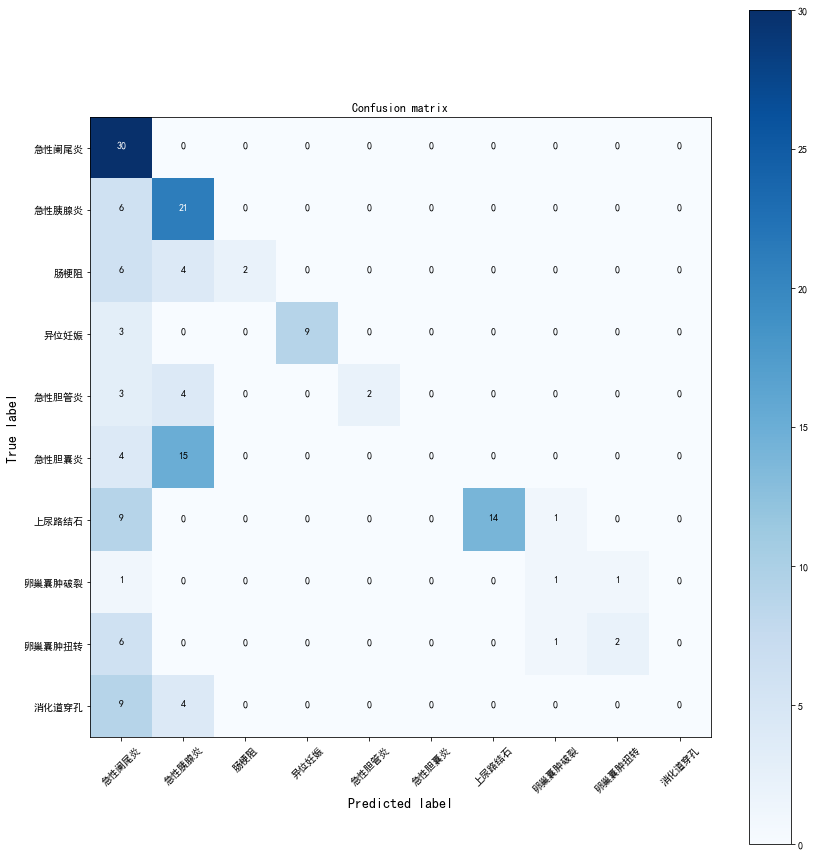

准确率: 51.27%


In [12]:
X, y, ids = load_data(r'data/人机大赛_临床合成.txt',
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_临床合成2345.pkl', r'output/models/diagnose/gbdt_临床合成2345_0.7058.m')
pred = dg.predict_one(X)

test_and_save(pred, y, ids, 'gbdt_人机大赛_临床合成2345')

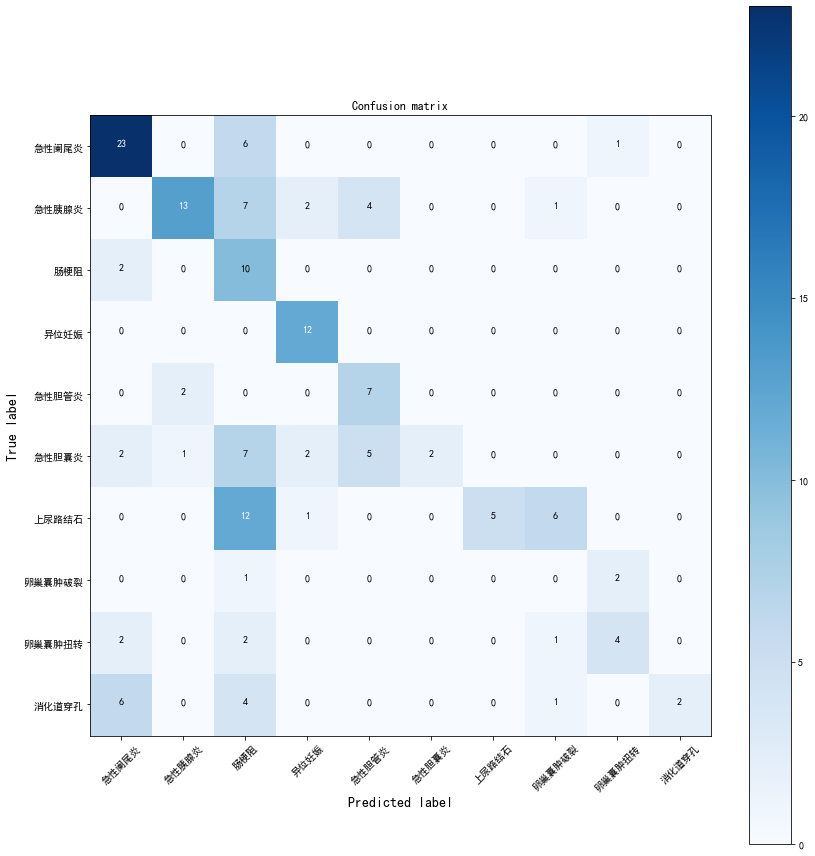

准确率: 49.37%


In [5]:
X, y, ids = load_data(r'data/人机大赛_临床实验室合成.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_临床实验室合成2345.pkl', r'output/models/diagnose/gbdt_临床实验室合成2345_0.7623.m')
pred = dg.predict_one(X)

test_and_save(pred, y, ids, 'gbdt_人机大赛_临床实验室合成2345')

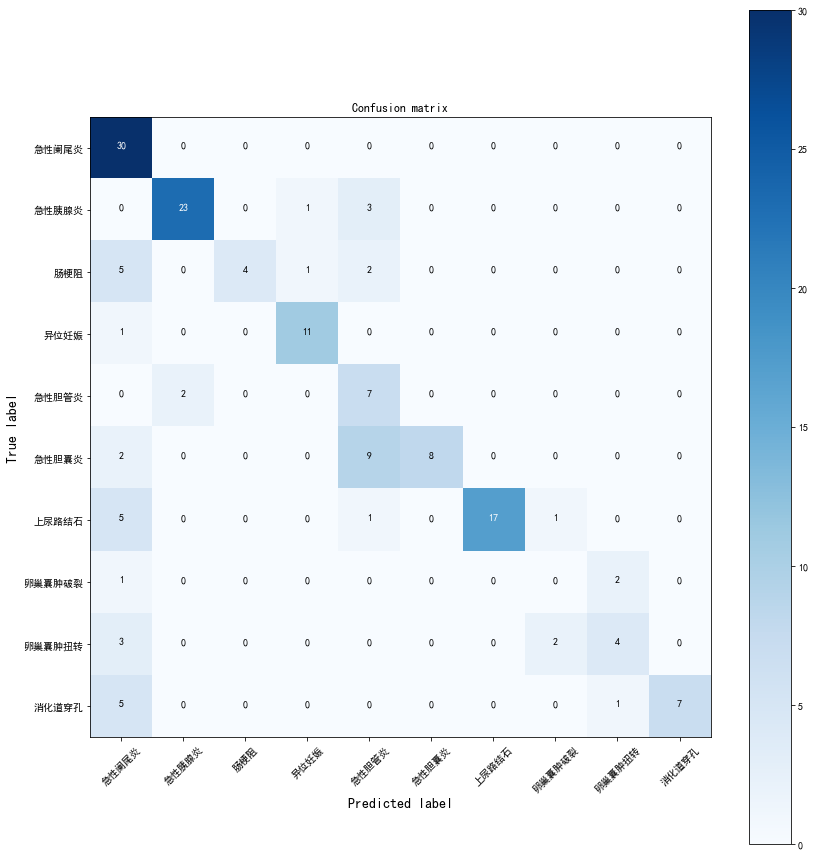

准确率: 70.25%


In [6]:
X, y, ids = load_data(r'data/人机大赛_全特征.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_全特征2345.pkl', r'output/models/diagnose/gbdt_全特征2345_0.8258.m')
pred = dg.predict_one(X)

test_and_save(pred, y, ids, 'gbdt_人机大赛_全特征2345')

### 跑前10的id数据

In [16]:
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_临床合成2345.pkl', r'output/models/diagnose/gbdt_临床合成2345_0.7058.m')

# 人机
X, y, ids = load_data(r'data/人机大赛_临床合成.txt', num_fields=171, separator='	', skip_title=True, 
                            cls_col=2, start_feature_col=3, end_feature_col=170, shuffle=False)
results = dg.predict_batch(X, pred_num=10, dict_name_id='id')
with open(r'output/data/人机大赛_临床合成.txt', 'w') as f:
    for r in results:
        s = str(r).replace('[', '').replace(']', '').replace(',', '	')
        f.write('%s\n' % s)
        
# 测试
X, y, ids = load_data(r'data/疾病诊断拟合_临床合成1.txt', num_fields=171, separator='	', skip_title=True, 
                            cls_col=2, start_feature_col=3, end_feature_col=170, shuffle=False)
results = dg.predict_batch(X, pred_num=10, dict_name_id='id')
with open(r'output/data/疾病诊断拟合_临床合成1.txt', 'w') as f:
    for r in results:
        s = str(r).replace('[', '').replace(']', '').replace(',', '	')
        f.write('%s\n' % s)

In [14]:
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_临床实验室合成2345.pkl', r'output/models/diagnose/gbdt_临床实验室合成2345_0.7623.m')

# 人机
X, y, ids = load_data(r'data/人机大赛_临床实验室合成.txt', num_fields=171, separator='	', skip_title=True, 
                            cls_col=2, start_feature_col=3, end_feature_col=170, shuffle=False)
results = dg.predict_batch(X, pred_num=10, dict_name_id='id')
with open(r'output/data/人机大赛_临床实验室合成.txt', 'w') as f:
    for r in results:
        s = str(r).replace('[', '').replace(']', '').replace(',', '	')
        f.write('%s\n' % s)
        
# 测试
X, y, ids = load_data(r'data/疾病诊断拟合_临床实验室合成1.txt', num_fields=171, separator='	', skip_title=True, 
                            cls_col=2, start_feature_col=3, end_feature_col=170, shuffle=False)
results = dg.predict_batch(X, pred_num=10, dict_name_id='id')
with open(r'output/data/疾病诊断拟合_临床实验室合成1.txt', 'w') as f:
    for r in results:
        s = str(r).replace('[', '').replace(']', '').replace(',', '	')
        f.write('%s\n' % s)

In [15]:
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_全特征2345.pkl', r'output/models/diagnose/gbdt_全特征2345_0.8258.m')

# 人机
X, y, ids = load_data(r'data/人机大赛_全特征.txt', num_fields=171, separator='	', skip_title=True, 
                            cls_col=2, start_feature_col=3, end_feature_col=170, shuffle=False)
results = dg.predict_batch(X, pred_num=10, dict_name_id='id')
with open(r'output/data/人机大赛_全特征.txt', 'w') as f:
    for r in results:
        s = str(r).replace('[', '').replace(']', '').replace(',', '	')
        f.write('%s\n' % s)
        
# 测试
X, y, ids = load_data(r'data/疾病诊断拟合_全特征1.txt', num_fields=171, separator='	', skip_title=True, 
                            cls_col=2, start_feature_col=3, end_feature_col=170, shuffle=False)
results = dg.predict_batch(X, pred_num=10, dict_name_id='id')
with open(r'output/data/疾病诊断拟合_全特征1.txt', 'w') as f:
    for r in results:
        s = str(r).replace('[', '').replace(']', '').replace(',', '	')
        f.write('%s\n' % s)
        


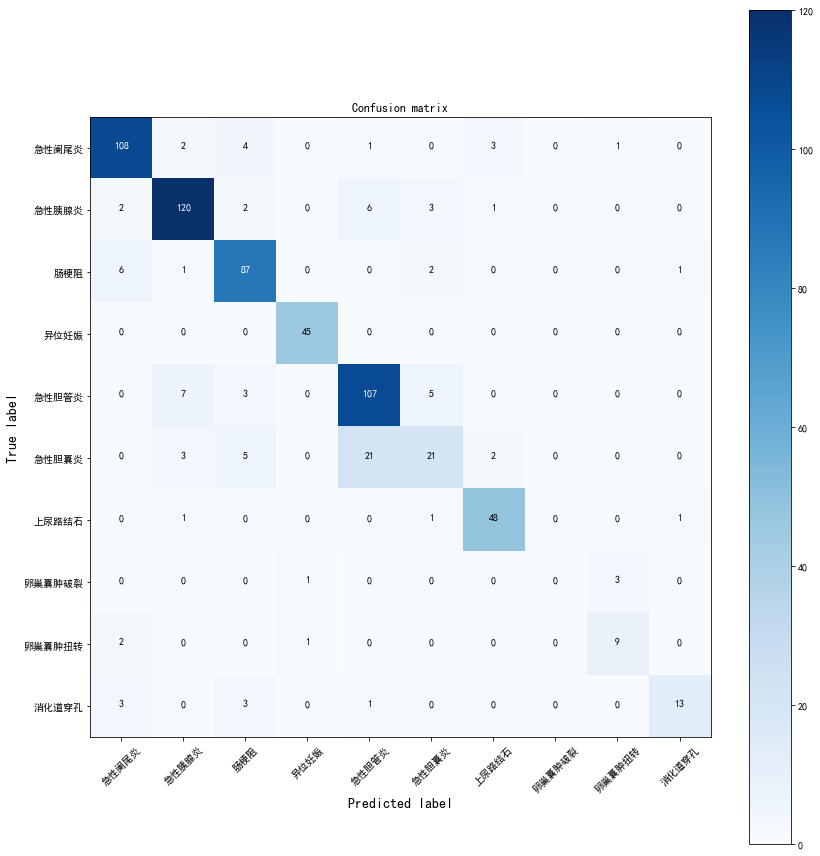

准确率: 85.06%


In [17]:
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_全特征2345.pkl', r'output/models/diagnose/gbdt_全特征2345_0.8258.m')
X, y, ids = load_data(r'data/疾病诊断拟合_全特征1.txt', num_fields=171, separator='	', skip_title=True, 
                            cls_col=2, start_feature_col=3, end_feature_col=170, shuffle=False)
pred = dg.predict_one(X)

test_and_save(pred, y, ids, '疾病诊断拟合_全特征1')

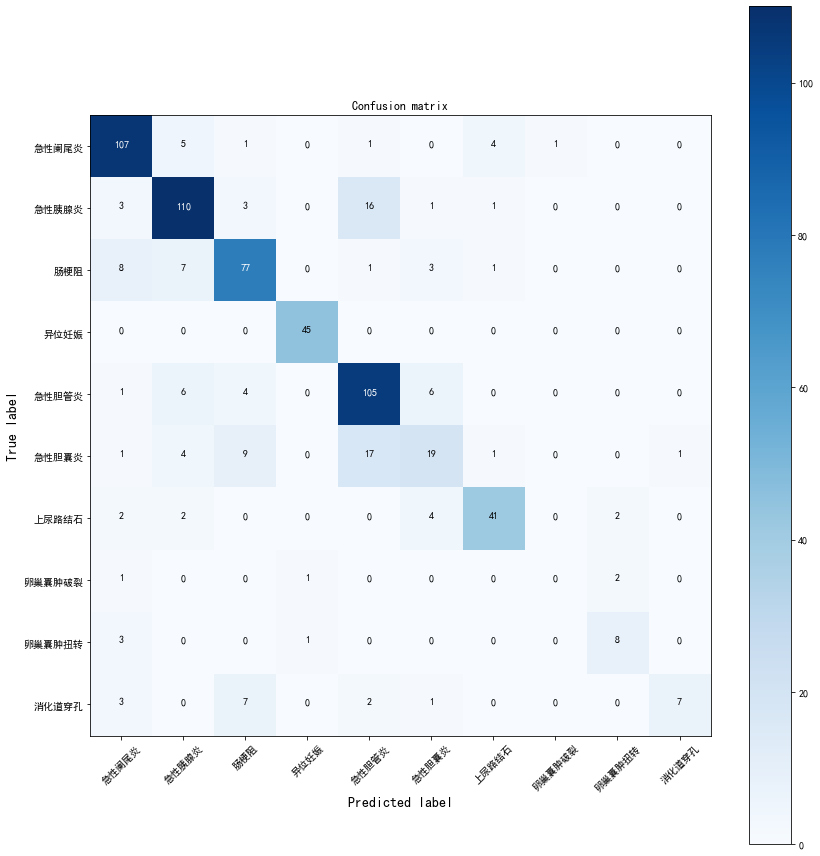

准确率: 79.12%


In [18]:
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_临床实验室合成2345.pkl', r'output/models/diagnose/gbdt_临床实验室合成2345_0.7623.m')
X, y, ids = load_data(r'data/疾病诊断拟合_临床实验室合成1.txt', num_fields=171, separator='	', skip_title=True, 
                            cls_col=2, start_feature_col=3, end_feature_col=170, shuffle=False)
pred = dg.predict_one(X)

test_and_save(pred, y, ids, '疾病诊断拟合_临床实验室合成1')

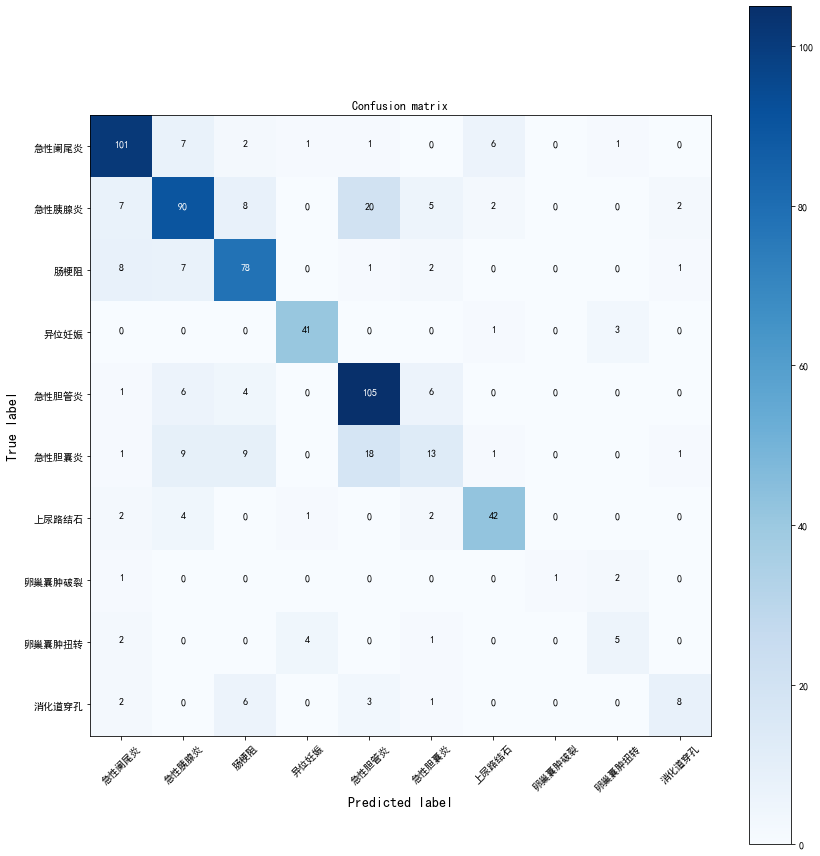

准确率: 73.78%


In [19]:
dg = Diagnoser(r'output/models/diagnose/scaler_gbdt_临床合成2345.pkl', r'output/models/diagnose/gbdt_临床合成2345_0.7058.m')
X, y, ids = load_data(r'data/疾病诊断拟合_临床合成1.txt', num_fields=171, separator='	', skip_title=True, 
                            cls_col=2, start_feature_col=3, end_feature_col=170, shuffle=False)
pred = dg.predict_one(X)

test_and_save(pred, y, ids, '疾病诊断拟合_临床合成1')